# Predicción del precio de Airbnb Madrid España: Pre-procesamiento y Modelado 

<div class="alert alert-info alert-info"><b><h1>Objetivo</h1></b>
    
**Crear un modelo de regresión lineal con el dataset previamente analizado, asi como utilizar las métricas para interpretar los resultados.**
</div>

## 1. Introducción:  

En el notebook anterior se realizó un análisis detallado de los precios de Airbnb en Madrid con R. Se llevaron a cabo los siguientes pasos: 
* Descripción de Datos.
* Limpieza y Preparación de Datos.
* Visualización de Datos. 

En este notebook, nos enfocaremos en aplicar técnicas de modelado y verificación del modelo para predecir los precios de los listados en Madrid. El objetivo final es desarrollar un modelo predictivo con regresión lineal, que pueda ayudar a sugerir precios para futuros listados de Airbnb en la ciudad.

## 2. Descripción de Variables:  


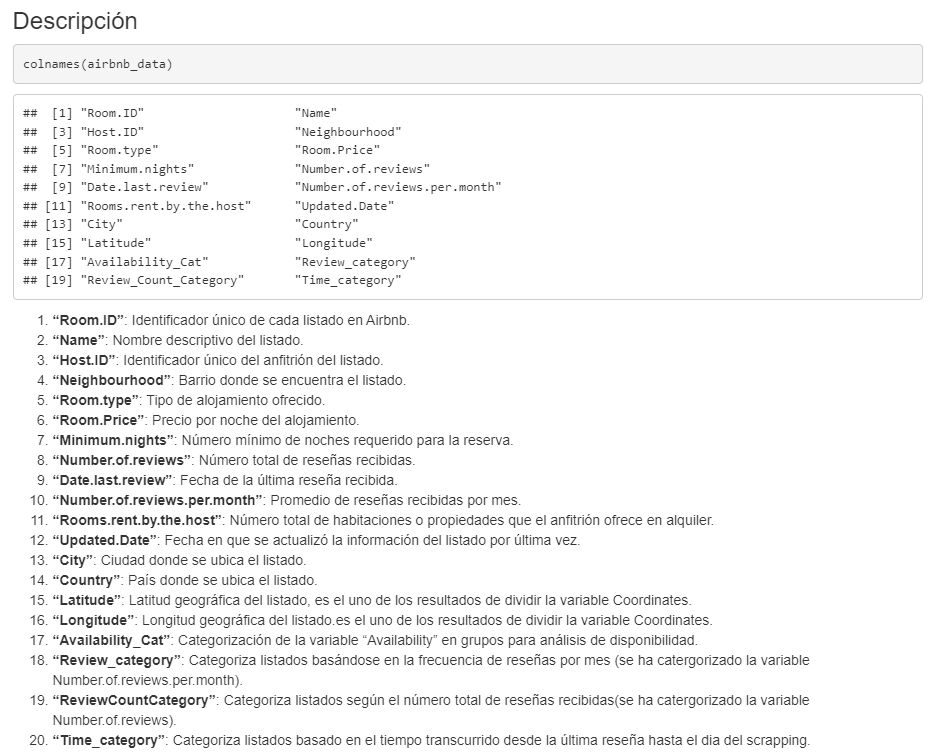

In [106]:
from IPython.display import Image
Image("/home/neivysg/keepcoding_glovo_bootcamp/Tech-Girls-Glovo/notebooks/variables.png")

---

## 3. Librerías a utilizar

In [107]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joypy
from joypy import joyplot


# Importar el módulo para la separación en train y test
from sklearn.model_selection import train_test_split

# Importar librerías para el análisis estadístico
from scipy import stats
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Importar los módulos para el preprocesado
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# Importar los módulos para la Regresión
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# Importar los módulos para los cálculos métricos
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics

# Importar módulo para el pipeline
from sklearn.pipeline import Pipeline

---

## 4. Dataset

In [108]:
df_airbnb_clean = pd.read_csv('/home/neivysg/keepcoding_glovo_bootcamp/Tech-Girls-Glovo/data/processed/processed-air-bnb-listings.csv', 
                              sep=';', 
                              encoding='UTF-8')

In [109]:
df_airbnb_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Room.ID                      21255 non-null  int64 
 1   Name                         21252 non-null  object
 2   Host.ID                      21255 non-null  int64 
 3   Neighbourhood                21255 non-null  object
 4   Room.type                    21255 non-null  object
 5   Room.Price                   21255 non-null  int64 
 6   Minimum.nights               21255 non-null  int64 
 7   Number.of.reviews            21255 non-null  int64 
 8   Date.last.review             15855 non-null  object
 9   Number.of.reviews.per.month  21255 non-null  object
 10  Rooms.rent.by.the.host       21255 non-null  int64 
 11  Updated.Date                 21255 non-null  object
 12  City                         21255 non-null  object
 13  Country                      21

In [110]:
df_airbnb_clean.head()

,Room.ID,Name,Host.ID,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Date.last.review,Number.of.reviews.per.month,Rooms.rent.by.the.host,Updated.Date,City,Country,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,21859113,Be Mate Plaza España Wild 203,157114944,Argüelles,Entire home/apt,147,1,1,2018-12-01,"0,05",36,2020-07-17,Madrid,Spain,"40,4219118238299","-3,71629887503917",No disponible,0-1/mes,1 reseña,1+ año
1,21862103,Designer flat in Madrid's exclusive Salamanca ...,8851341,Recoletos,Entire home/apt,625,5,2,2018-08-09,"0,06",1,2020-07-17,Madrid,Spain,"40,4220548771786","-3,68896132029749",91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,21875158,Estudio de diseño en pleno centro de Madrid,159570292,Sol,Private room,500,1,110,2020-02-26,"3,41",2,2020-07-17,Madrid,Spain,"40,4157379439854","-3,70441664509817",181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,21932504,Cosy apartment in the cosmopolitan Gran Vía,160055902,Palacio,Entire home/apt,62,2,194,2020-03-11,"6,16",1,2020-07-17,Madrid,Spain,"40,421747567976","-3,71099451203024",181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,22042300,Habitación 1. Para estudiar o trabajar,160981040,Portazgo,Private room,12,15,11,2018-10-30,"0,4",3,2020-07-17,Madrid,Spain,"40,391493766002","-3,64508317610579",91 a 180 días,0-1/mes,11-50 reseñas,1+ año


## 5. Análisis General

### 5.1. Verificar nulos y NaM

In [111]:
df_airbnb_clean.isnull().sum()

Room.ID                           0
Name                              3
Host.ID                           0
Neighbourhood                     0
Room.type                         0
Room.Price                        0
Minimum.nights                    0
Number.of.reviews                 0
Date.last.review               5400
Number.of.reviews.per.month       0
Rooms.rent.by.the.host            0
Updated.Date                      0
City                              0
Country                           0
Latitude                          0
Longitude                         0
Availability_Cat                  0
Review_category                   0
Review_Count_Category             0
Time_category                     0
dtype: int64

In [112]:
df_airbnb_clean.isna().sum()

Room.ID                           0
Name                              3
Host.ID                           0
Neighbourhood                     0
Room.type                         0
Room.Price                        0
Minimum.nights                    0
Number.of.reviews                 0
Date.last.review               5400
Number.of.reviews.per.month       0
Rooms.rent.by.the.host            0
Updated.Date                      0
City                              0
Country                           0
Latitude                          0
Longitude                         0
Availability_Cat                  0
Review_category                   0
Review_Count_Category             0
Time_category                     0
dtype: int64

### 5.2. Verificar datos duplicados

In [113]:
df_airbnb_clean[df_airbnb_clean.duplicated()]

,Room.ID,Name,Host.ID,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Date.last.review,Number.of.reviews.per.month,Rooms.rent.by.the.host,Updated.Date,City,Country,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category


**Observaciones:**

   *  Se puede observar que el dataset  tiene valores nulos o NaN en las columnas names y Date.last.review. 
   *  Se puede observar que el data set no tiene valores duplicados.   
   * Se tienen 14 variables objetos y 6 integer.
   * Basado en el Análisis Exploratorio previo (Cuaderno R) se tienen seleccionadas inicialmente para el modelo de predicción los siguientes atributos; sin embargo, previamente se realizará un análisis estadístico preliminar a la selección final o caso base:
      - Atributo objetivo: Room.Price
      - Numéricas: Minimum.nights, Number.of.reviews, Number.of.reviews.per.month, Latitude, Longitude.
      - Categóricas: Neighbourhood, Room.type, Availability_Cat, Review_category, Review_Count_Category, Time_category.
   * Se descartarán los atributos: Room.ID, Name, Host.ID, Date.last.review, Updated.Date, City, Country. 

### 5.3. Eliminar atributos

De acuerdo al analisis exploratorio previo, se eliminaran los atributos: Room.ID, Name, Host.ID, Date.last.review, Updated.Date, City, Country, como primer descarte.

In [114]:
df_airbnb_clean_vs_1 = df_airbnb_clean.drop(['Room.ID', 'Name', 'Host.ID', 'Date.last.review', 'Updated.Date', 'City', 'Country'], axis=1)

In [115]:
df_airbnb_clean_vs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Neighbourhood                21255 non-null  object
 1   Room.type                    21255 non-null  object
 2   Room.Price                   21255 non-null  int64 
 3   Minimum.nights               21255 non-null  int64 
 4   Number.of.reviews            21255 non-null  int64 
 5   Number.of.reviews.per.month  21255 non-null  object
 6   Rooms.rent.by.the.host       21255 non-null  int64 
 7   Latitude                     21255 non-null  object
 8   Longitude                    21255 non-null  object
 9   Availability_Cat             21255 non-null  object
 10  Review_category              21255 non-null  object
 11  Review_Count_Category        21255 non-null  object
 12  Time_category                21255 non-null  object
dtypes: int64(4), object(9)
memory u

### 5.4. Verificar tipos de datos

In [116]:
# Verificar tipos de datos
print(df_airbnb_clean_vs_1.dtypes)

Neighbourhood                  object
Room.type                      object
Room.Price                      int64
Minimum.nights                  int64
Number.of.reviews               int64
Number.of.reviews.per.month    object
Rooms.rent.by.the.host          int64
Latitude                       object
Longitude                      object
Availability_Cat               object
Review_category                object
Review_Count_Category          object
Time_category                  object
dtype: object


Dado que Latitude, Longitude y Number.of.reviews.per.month están etiquetados como object, necesitamos convertir estas columnas a tipo numérico

In [117]:
# Convertir columnas a tipo numérico
df_airbnb_clean_vs_1['Latitude'] = df_airbnb_clean_vs_1['Latitude'].str.replace(',', '.').astype(float)
df_airbnb_clean_vs_1['Longitude'] = df_airbnb_clean_vs_1['Longitude'].str.replace(',', '.').astype(float)
df_airbnb_clean_vs_1['Number.of.reviews.per.month'] = df_airbnb_clean_vs_1['Number.of.reviews.per.month'].str.replace(',', '.').astype(float)

In [118]:
df_airbnb_clean_vs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighbourhood                21255 non-null  object 
 1   Room.type                    21255 non-null  object 
 2   Room.Price                   21255 non-null  int64  
 3   Minimum.nights               21255 non-null  int64  
 4   Number.of.reviews            21255 non-null  int64  
 5   Number.of.reviews.per.month  21255 non-null  float64
 6   Rooms.rent.by.the.host       21255 non-null  int64  
 7   Latitude                     21255 non-null  float64
 8   Longitude                    21255 non-null  float64
 9   Availability_Cat             21255 non-null  object 
 10  Review_category              21255 non-null  object 
 11  Review_Count_Category        21255 non-null  object 
 12  Time_category                21255 non-null  object 
dtypes: float64(3), i

In [119]:
df_airbnb_clean_vs_1.head()

,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Number.of.reviews.per.month,Rooms.rent.by.the.host,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Argüelles,Entire home/apt,147,1,1,0.05,36,40.421912,-3.716299,No disponible,0-1/mes,1 reseña,1+ año
1,Recoletos,Entire home/apt,625,5,2,0.06,1,40.422055,-3.688961,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Sol,Private room,500,1,110,3.41,2,40.415738,-3.704417,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Palacio,Entire home/apt,62,2,194,6.16,1,40.421748,-3.710995,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Portazgo,Private room,12,15,11,0.40,3,40.391494,-3.645083,91 a 180 días,0-1/mes,11-50 reseñas,1+ año


### 5.5. Descripción estadística y visualización global de las variables.

Para determinar qué variables mantener para el modelo de predicción, necesitamos evaluar su correlación con el precio de la habitación (Room.Price) y considerar otras técnicas estadísticas. Los pasos serán:

1. Sumario estadístico: Numéricas y categóricas.
2. Evaluar la correlación: Ver la correlación de los atributos numéricos con Room.Price.
3. Análisis de varianza: Evaluar variables categóricas con ANOVA.
4. Aplicación de prueba de hipótesis para chequear la distribución normal

#### 5.5.1 Sumario Estadístico:

##### Variables Numéricas

In [120]:
def estadisticos_num(cont_data):
    #Calcular estadísticas descriptivas, redondeamos y transponemos
    estadisticos = cont_data.describe().round(3).T
    #Añadir la mediana
    estadisticos['median'] = cont_data.median().round(3)
    #Reordenar para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Pedir que nos devuelva los cálculos realizados
    return(estadisticos)

In [121]:
# Aplicar la función a las variables numéricas
Num_data = df_airbnb_clean_vs_1.select_dtypes(['float64', 'int64'])
Num_data

,Room.Price,Minimum.nights,Number.of.reviews,Number.of.reviews.per.month,Rooms.rent.by.the.host,Latitude,Longitude
0,147,1,1,0.05,36,40.421912,-3.716299
1,625,5,2,0.06,1,40.422055,-3.688961
2,500,1,110,3.41,2,40.415738,-3.704417
3,62,2,194,6.16,1,40.421748,-3.710995
4,12,15,11,0.40,3,40.391494,-3.645083
...,...,...,...,...,...,...,...
21250,59,1,0,0.00,1,40.432952,-3.652199
21251,120,1,7,0.22,23,40.392654,-3.716037
21252,90,1,57,1.76,1,40.429886,-3.721570
21253,48,30,57,1.77,1,40.410442,-3.702625


In [122]:
estadisticos_num(Num_data)

,count,mean,median,std,min,25%,50%,75%,max
Room.Price,21255.0,163.985,60.000,559.471,0.000,36.000,60.000,100.000,9999.000
Minimum.nights,21255.0,5.522,2.000,28.147,1.000,1.000,2.000,3.000,1125.000
Number.of.reviews,21255.0,34.875,6.000,65.110,0.000,0.000,6.000,38.000,661.000
Number.of.reviews.per.month,21255.0,1.065,0.390,1.508,0.000,0.000,0.390,1.540,27.250
Rooms.rent.by.the.host,21255.0,14.246,2.000,39.299,1.000,1.000,2.000,7.000,244.000
Latitude,21255.0,40.421,40.420,0.022,40.332,40.410,40.420,40.430,40.563
Longitude,21255.0,-3.694,-3.701,0.028,-3.864,-3.708,-3.701,-3.687,-3.524


**Observaciones:**

* Room.Price: El precio medio de una habitación es de aproximadamente 164, pero la mediana es solo 60, lo que indica que hay algunos valores extremadamente altos (como el máximo de 9999) que están elevando la media. El 75% de las habitaciones cuestan 100 o menos.

* Minimum.nights: La mayoría de las estancias requieren muy pocas noches, con una mediana de solo 2 noches. Sin embargo, el máximo es de 1125 noches, lo que indica que hay algunas que requieren estancias extremadamente largas.

* Number.of.reviews: La mayoría de las habitaciones tienen pocas reseñas, con una mediana de solo 6 reseñas. Sin embargo, la media es de 34.875, lo que indica que hay algunas habitaciones con un número muy alto de reseñas.

* Number.of.reviews.per.month: Similar a Number.of.reviews, la mayoría de las habitaciones tienen pocas reseñas por mes, pero hay algunas habitaciones con un número muy alto de reseñas por mes.

* Rooms.rent.by.the.host: La mayoría de los anfitriones alquilan pocas habitaciones, con una mediana de solo 2 habitaciones. Sin embargo, el máximo es de 244, lo que indica que hay algunos anfitriones que alquilan un gran número de habitaciones.

* Latitude y Longitude: Estas son las coordenadas geográficas de las habitaciones. No hay mucho que analizar aquí sin un contexto geográfico adicional.

En general, parece que hay una gran variabilidad en los datos, con algunos valores extremos en varias columnas. Esto podría afectar a los modelos de machine learning si no se manejan adecuadamente. En el caso de la discretización es una buena estrategia para manejar variables numéricas con muchos valores únicos o con valores extremos. Al convertir "Number.of.reviews" y "Number.of.reviews.per.month" en categorías, reduces la complejidad de los datos y puedes ayudar al modelo a capturar patrones más generales.

##### Variables Categoricas

In [123]:
cat = df_airbnb_clean_vs_1.select_dtypes('object')
cat

,Neighbourhood,Room.type,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Argüelles,Entire home/apt,No disponible,0-1/mes,1 reseña,1+ año
1,Recoletos,Entire home/apt,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Sol,Private room,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Palacio,Entire home/apt,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Portazgo,Private room,91 a 180 días,0-1/mes,11-50 reseñas,1+ año
...,...,...,...,...,...,...
21250,Quintana,Private room,61 a 90 días,sin reseñas,sin reseñas,sin reseñas
21251,Opañel,Entire home/apt,No disponible,0-1/mes,2-10 reseñas,1+ año
21252,Argüelles,Entire home/apt,181 a 365 días,1-5/mes,51-100 reseñas,6-12 meses
21253,Embajadores,Entire home/apt,31 a 60 días,1-5/mes,51-100 reseñas,8 semanas - 6 meses


In [124]:
cat.describe()

,Neighbourhood,Room.type,Availability_Cat,Review_category,Review_Count_Category,Time_category
count,21255,21255,21255,21255,21255,21255
unique,127,4,6,4,6,5
top,Embajadores,Entire home/apt,181 a 365 días,0-1/mes,sin reseñas,8 semanas - 6 meses
freq,2559,12704,8186,8771,5400,7150


**Observaciones:**

* Neighbourhood: Hay 21255 observaciones no nulas, 127 barrios únicos, el barrio más común es "Embajadores", y "Embajadores" aparece 2559 veces.

* Room.type: Hay 21255 observaciones no nulas, 4 tipos de habitaciones únicos, el tipo de habitación más común es "Entire home/apt", y "Entire home/apt" aparece 12704 veces.

* Availability_Cat: Hay 21255 observaciones no nulas, 6 categorías de disponibilidad únicas, la categoría de disponibilidad más común es "181 a 365 días", y "181 a 365 días" aparece 8186 veces.

* Review_category: Hay 21255 observaciones no nulas, 4 categorías de revisión únicas, la categoría de revisión más común es "0-1/mes", y "0-1/mes" aparece 8771 veces.

* Review_Count_Category: Hay 21255 observaciones no nulas, 6 categorías de conteo de revisión únicas, la categoría de conteo de revisión más común es "sin reseñas", y "sin reseñas" aparece 5400 veces.

* Time_category: Hay 21255 observaciones no nulas, 5 categorías de tiempo únicas, la categoría de tiempo más común es "8 semanas - 6 meses", y "8 semanas - 6 meses" aparece 7150 veces.

* Estos resúmenes nos dan una idea de la distribución de las variables categóricas. Para usar estas variables en un modelo de machine learning, se tendrán que codificar en una forma que el modelo pueda entender, como one-hot encoding, ordinal encoding, target encoding, etc.

#### 5.5.2 Evaluar la Correlación de atributos numéricos:

El atributo Room.Price será el target o variable de predicción. Se crearán unos gráficos de dispersión de los atributos en función del atributo Room.Prices para ver su relación.

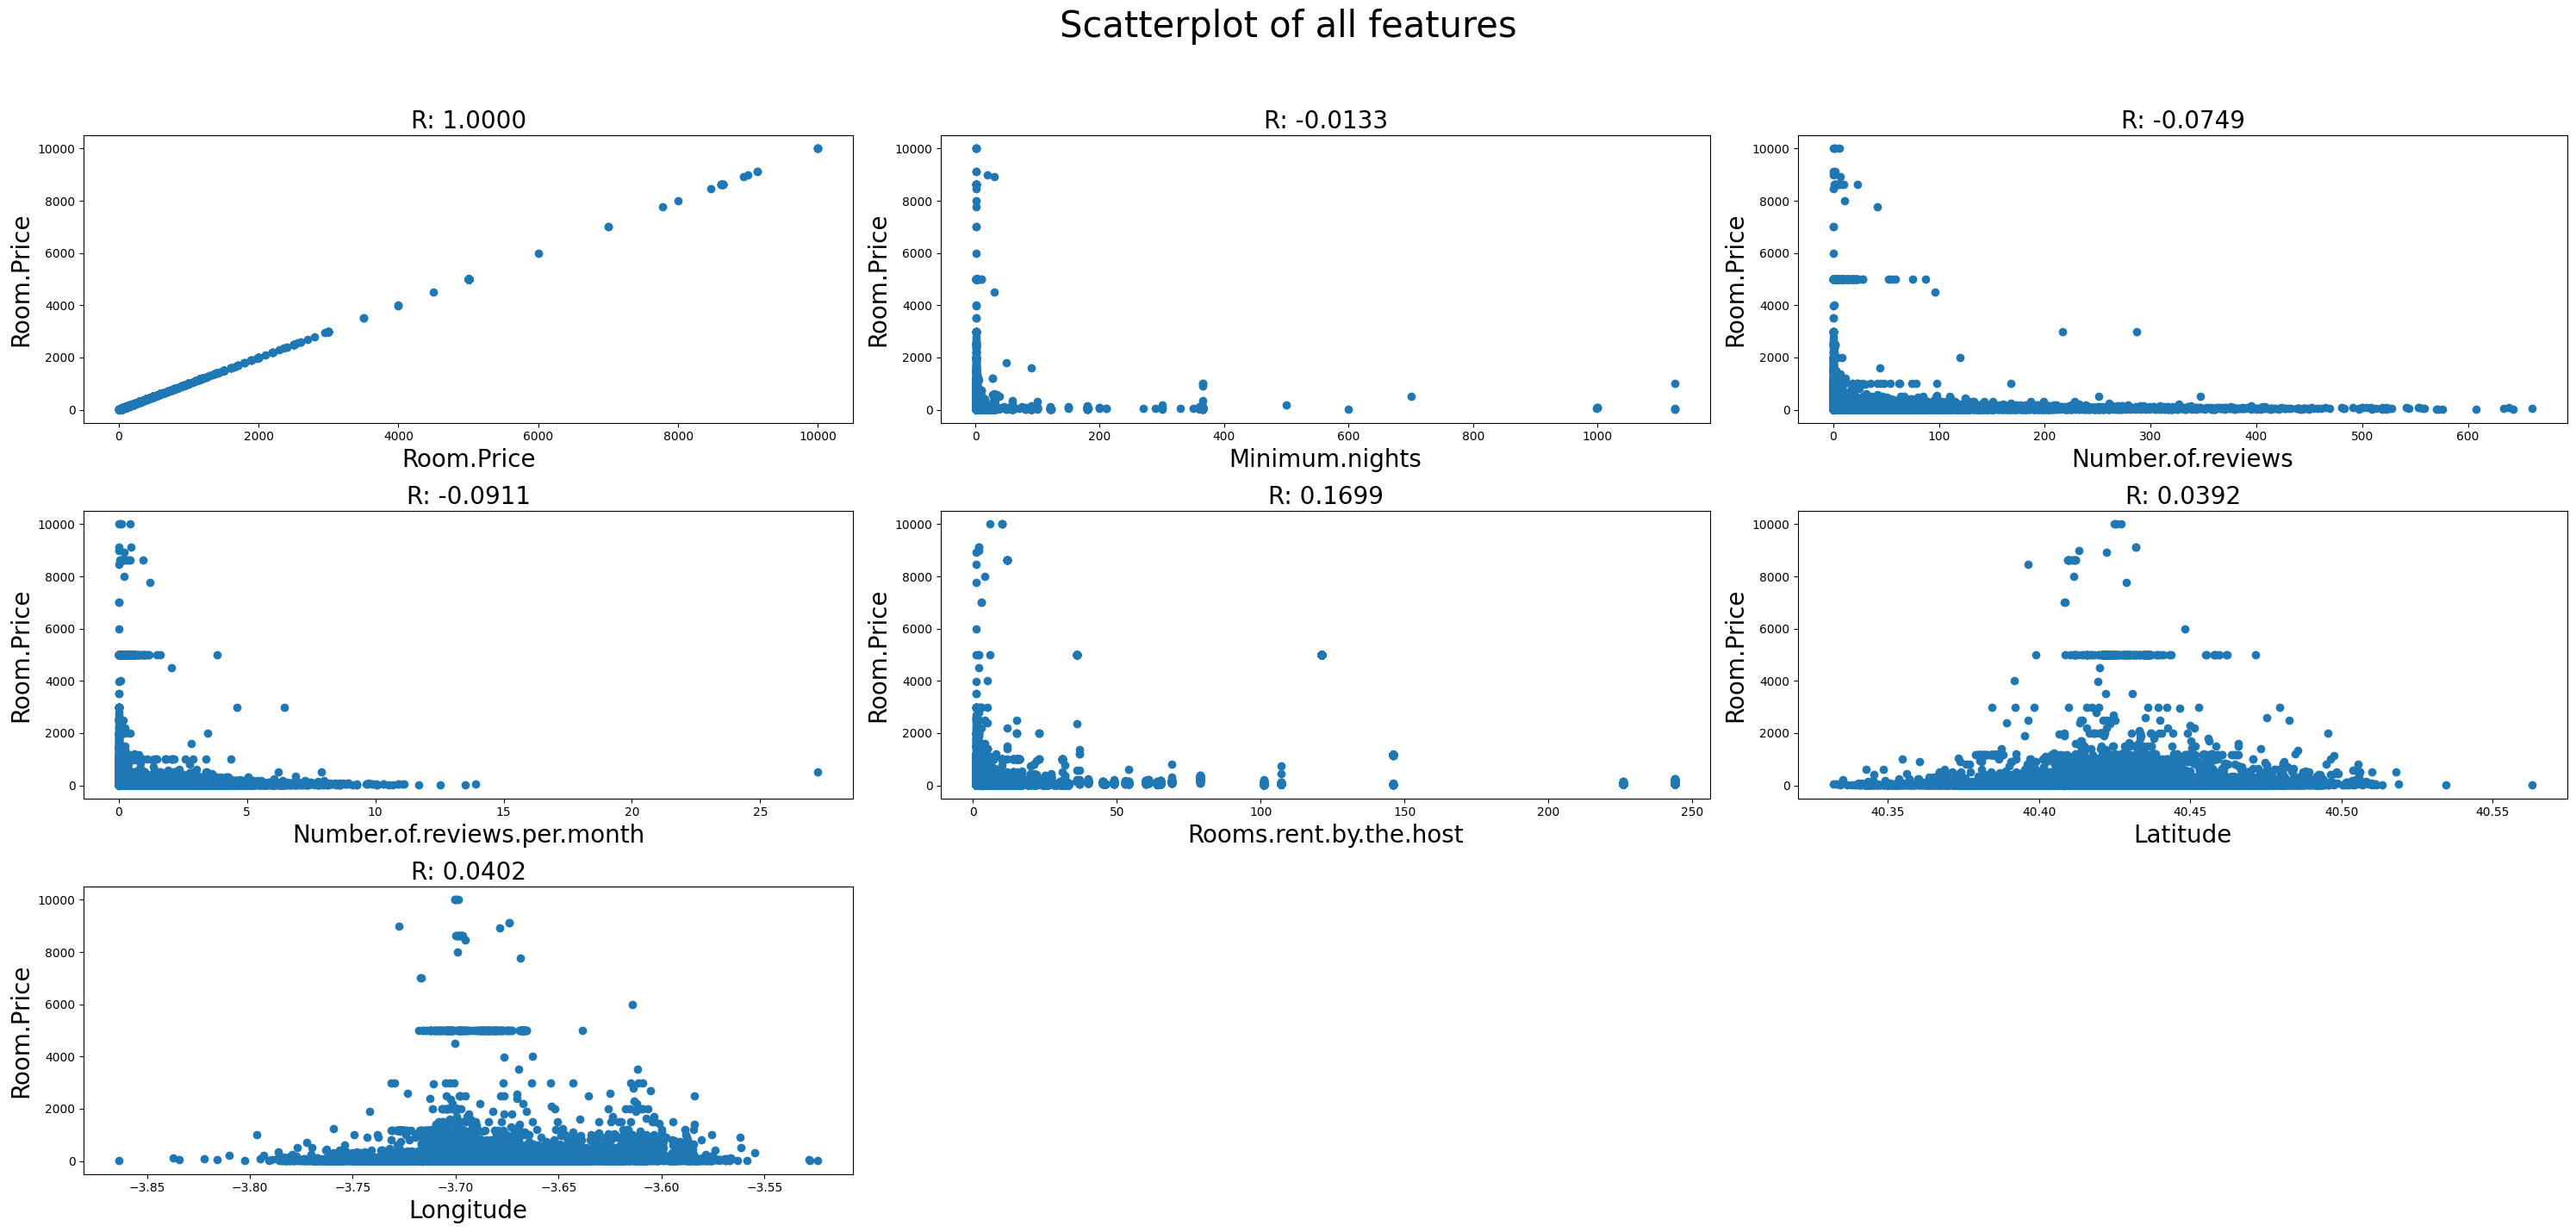

In [125]:
## Asignar el índice de la columna que queremos seleccionar
col_idx = 0

## Crear gráficos con cuatro columnas y tres filas
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(30, 15))

## Recorrer cada subplot y hacemos un scatterplot
for i in range(3):
    for j in range(3):
        if col_idx < len(Num_data.columns):
            col = Num_data.columns[col_idx]
            if np.issubdtype(Num_data[col].dtype, np.number):  # Comprueba si la columna es numerica
                axes[i, j].plot(Num_data[col], Num_data['Room.Price'], 'o', color='tab:blue')
                axes[i, j].set_xlabel(Num_data.columns[col_idx], fontsize=20)
                axes[i, j].set_ylabel('Room.Price', fontsize=20)
                axes[i, j].set_title('R: {:.4f}'.format(Num_data[['Room.Price', col]].corr().iloc[0, 1]), fontsize=20)
                fig.suptitle('Scatterplot of all features', fontsize=30)
            col_idx += 1
        else:
            axes[i, j].axis('off')  # Desactiva el eje si no hay más columnas disponibles

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta el espacio entre subplots
plt.show()

Room.Price                     1.000000
Rooms.rent.by.the.host         0.169926
Longitude                      0.040240
Latitude                       0.039231
Minimum.nights                -0.013299
Number.of.reviews             -0.074905
Number.of.reviews.per.month   -0.091059
Name: Room.Price, dtype: float64


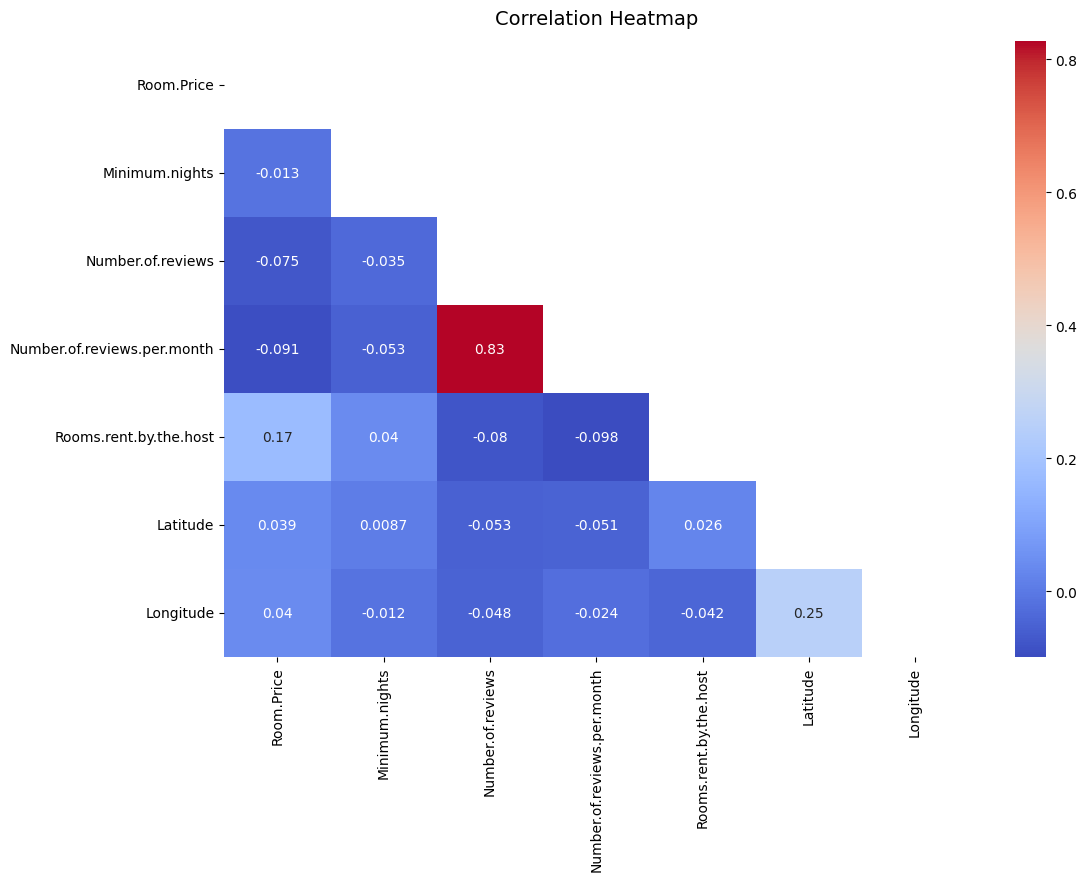

In [126]:
# Calcular la correlación
correlation_matrix = Num_data.corr()
print(correlation_matrix['Room.Price'].sort_values(ascending=False))

# Crear la máscara
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
ax.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

**Observaciones:**

#### 5.5.3 Análisis de Varianza (ANOVA) 

Análisis de Varianza (ANOVA) para Variables Categóricas: 
Evaluemos las variables categóricas (Neighbourhood, Room.type, City, Country, Availability_Cat, Review_category, Review_Count_Category, Time_category) con ANOVA para ver si tienen una relación significativa con Room.Price.

In [127]:
# Reemplazar los puntos en los nombres de las columnas con guiones bajos
df_airbnb_clean_vs_1.columns = df_airbnb_clean_vs_1.columns.str.replace('.', '_')

In [128]:
# Realizar ANOVA para cada variable categórica
anova_results = {}

for var in df_airbnb_clean_vs_1.columns:
    if var != 'Room_Price':
        model = ols(f'Room_Price ~ {var}', data=df_airbnb_clean_vs_1).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[var] = anova_table

# Mostrar resultados
for var, anova_table in anova_results.items():
    print(f"ANOVA results for {var}:")
    print(anova_table)
    print("\n")

ANOVA results for Neighbourhood:
                     sum_sq       df         F        PR(>F)
Neighbourhood  1.724252e+08    126.0  4.461674  2.151438e-55
Residual       6.480234e+09  21128.0       NaN           NaN


ANOVA results for Room_type:
                 sum_sq       df          F        PR(>F)
Room_type  6.411966e+07      3.0  68.938242  2.331318e-44
Residual   6.588539e+09  21251.0        NaN           NaN


ANOVA results for Minimum_nights:
                      sum_sq       df         F    PR(>F)
Minimum_nights  1.176598e+06      1.0  3.759499  0.052522
Residual        6.651482e+09  21253.0       NaN       NaN


ANOVA results for Number_of_reviews:
                         sum_sq       df           F        PR(>F)
Number_of_reviews  3.732673e+07      1.0  119.919142  7.820650e-28
Residual           6.615332e+09  21253.0         NaN           NaN


ANOVA results for Number_of_reviews_per_month:
                                   sum_sq       df           F        PR(>F)
Num

**Observaciones:**
* Room_type: Con un valor F de 68.94 y un valor p extremadamente pequeño (2.33e-44), esto indica que el tipo de habitación tiene un efecto significativo en el precio de la habitación.

* Number_of_reviews: Con un valor F de 119.92 y un valor p extremadamente pequeño (7.82e-28), esto indica que el número de revisiones tiene un efecto significativo en el precio de la habitación.

* Number_of_reviews_per_month: Con un valor F de 177.70 y un valor p extremadamente pequeño (2.24e-40), esto indica que el número de revisiones por mes tiene un efecto significativo en el precio de la habitación.

* Rooms_rent_by_the_host: Con un valor F de 631.93 y un valor p extremadamente pequeño (1.93e-137), esto indica que el número de habitaciones alquiladas por el anfitrión tiene un efecto significativo en el precio de la habitación.

* Latitude y Longitude: Ambas tienen valores F significativos y valores p muy pequeños, lo que indica que la ubicación geográfica de la habitación (latitud y longitud) tiene un efecto significativo en el precio de la habitación.

* Availability_Cat, Review_category, Review_Count_Category, y Time_category: Todas estas variables tienen valores F significativos y valores p muy pequeños, lo que indica que tienen un efecto significativo en el precio de la habitación.

En resumen, todas las variables, excepto Minimum_nights, parecen tener un efecto significativo en el precio de la habitación, según los resultados de ANOVA.

#### 5.5.4 Aplicación de prueba de hipótesis para chequear la distribución normal

In [129]:
def check_normal_distribution(data):
    for i in data.columns:
        shapiro_test = stats.shapiro(data[i])
        print('La variable', i, 'tiene un p-value= ', shapiro_test.pvalue)
        if shapiro_test.pvalue>0.05:
            print('Se acepta la hipotesis nula, la muestra tiene una distribución normal (Probablemente Gaussiana).\n')
        else:
            print('Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).\n')

In [130]:
check_normal_distribution(Num_data)

La variable Room.Price tiene un p-value=  8.018527685228153e-131
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Minimum.nights tiene un p-value=  2.394018233826201e-134
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Number.of.reviews tiene un p-value=  8.559543693623246e-113
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Number.of.reviews.per.month tiene un p-value=  8.028584837995182e-102
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Rooms.rent.by.the.host tiene un p-value=  1.3149428122259552e-124
Se rechaza la hipotesis nula, la muestra no tiene una distribución normal (Probablemente no Gaussiana).

La variable Latitude tiene un p-value=  2.1198806788095576e-61
Se rechaza la hipotesis nula, la muestra no ti

/home/neivysg/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21255.
  res = hypotest_fun_out(*samples, **kwds)


## 6. Pre-Procesamiento

Una vez realizado el análisis general del dataset limpio y seleccionados los atributos para la predicción del precio, se aplicarán al preprocesamiento de los datos las siguientes normalizaciones: 


**Atributos Categóricos:** En el caso de los atributos categoricos se utlizará el  OneHotEncoder con ColumnTransformer:
 * Neighbourhood
 * Room.type	
 * Availability_Cat	
 * Review_category y Review_Count_Category: en cuanto a los atributos Number.of.reviews" y "Number.of.reviews.per.month" se observó una gran variabilidad en sus datos, por lo cual fueron convertidas en categóricas en el análisis exploratorio en R. 

**Atributos Numéricos:** 
Dado que las variables numéricas independientes no tienen distribucción normal o gausiona se les aplicara normalización:
 * Outliers: De acuerdo al analisis exploratorio en R, se tienen los siguientes atributos con outliers: Minimum.nights, Rooms.rent.by.the.host, Latitude y Longitude por lo que se le aplicará **RobustScaler**.

In [131]:
# Se crea una copia del dataframe original con la eliminación de la columna 'Time_category'
df_airbnb_transformed = df_airbnb_clean_vs_1.drop(['Number_of_reviews', 'Number_of_reviews_per_month'], axis=1)

In [132]:
df_airbnb_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighbourhood           21255 non-null  object 
 1   Room_type               21255 non-null  object 
 2   Room_Price              21255 non-null  int64  
 3   Minimum_nights          21255 non-null  int64  
 4   Rooms_rent_by_the_host  21255 non-null  int64  
 5   Latitude                21255 non-null  float64
 6   Longitude               21255 non-null  float64
 7   Availability_Cat        21255 non-null  object 
 8   Review_category         21255 non-null  object 
 9   Review_Count_Category   21255 non-null  object 
 10  Time_category           21255 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.8+ MB


### 6.1. Transformaciones numéricas:

In [133]:
##Outliers
columns_outliers =['Minimum_nights', 'Rooms_rent_by_the_host', 'Latitude', 'Longitude']
Robust_scaler = preprocessing.RobustScaler().fit(df_airbnb_transformed[columns_outliers])
df_airbnb_transformed[columns_outliers] = Robust_scaler.transform(df_airbnb_transformed[columns_outliers])

#dataset normalizado
df_airbnb_transformed.head()

,Neighbourhood,Room_type,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Argüelles,Entire home/apt,147,-0.5,5.666667,0.106046,-0.725884,No disponible,0-1/mes,1 reseña,1+ año
1,Recoletos,Entire home/apt,625,1.5,-0.166667,0.113060,0.579385,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Sol,Private room,500,-0.5,0.000000,-0.196682,-0.158551,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Palacio,Entire home/apt,62,0.0,-0.166667,0.097992,-0.472620,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Portazgo,Private room,12,6.5,0.166667,-1.385461,2.674405,91 a 180 días,0-1/mes,11-50 reseñas,1+ año


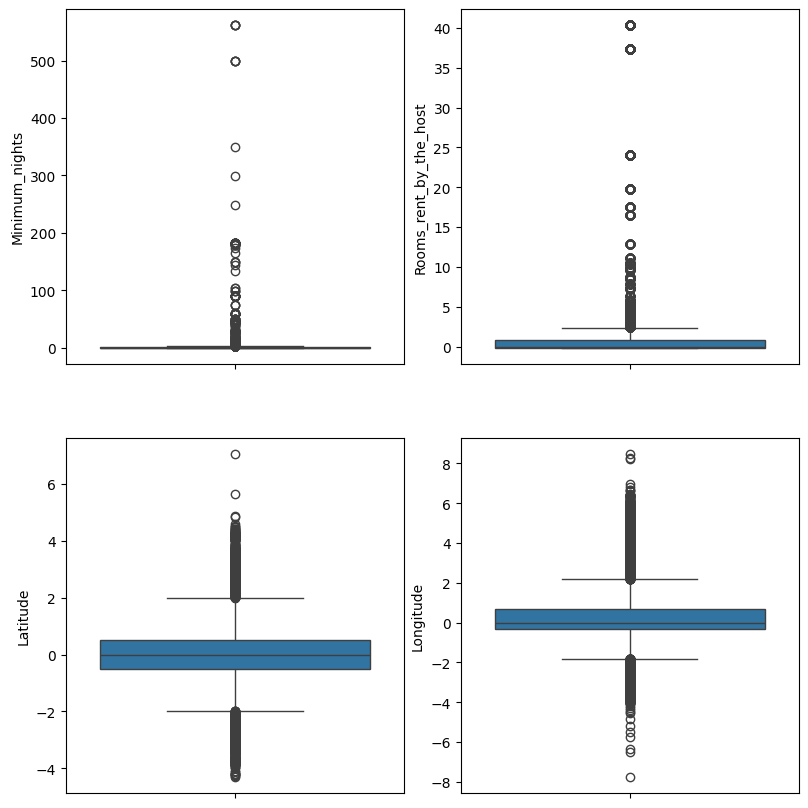

In [134]:
### gráfico para ver la mejora

variables = ['Minimum_nights', 'Rooms_rent_by_the_host', 'Latitude', 'Longitude']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
axs = axs.flatten()

for index, variable in enumerate(variables):
    sns.boxplot(y=variable, data=df_airbnb_transformed, ax=axs[index])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

A pesar de las transformaciones, no mejoran significativamente los valores de los outliers, por lo que se puede plantear probar un modelo eliminando los outliers.

### 

### 6.2. Transformaciones Categóricas:

Para la transformación de las variables categóricas, existen diferentes tecnicas, sin embargo las mas comunes son una técnica llamada codificación one-hot de sklearn y en Python, puedes usar la función get_dummies() de pandas para hacer esto. Para el proyecto se utilizará Sklearn OneHotEncoder con ColumnTransformer, es más robusto y flexible, especialmente si estás construyendo un pipeline de machine learning que incluye preprocesamiento y modelado. 
Puede manejar nuevas categorías en los datos de prueba que no estaban presentes en los datos de entrenamiento. Además, permite aplicar diferentes transformaciones a diferentes columnas, lo que es útil si también necesitas preprocesar variables numéricas de diferentes maneras.

In [135]:
# Definir las columnas categóricas que quieres transformar
categorical_features = ['Neighbourhood', 'Room_type', 'Availability_Cat', 'Review_category', 'Review_Count_Category', 'Time_category']

# Crear el OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Ajustar y transformar tus datos
categorical_transformed = encoder.fit_transform(df_airbnb_transformed[categorical_features])

In [136]:
# Convertir a DataFrame
categorical_transformed = pd.DataFrame(categorical_transformed.toarray(), columns=encoder.get_feature_names_out(categorical_features))

In [137]:
# Eliminar las columnas categóricas originales de df_airbnb_transformed
df_airbnb_transformed = df_airbnb_transformed.drop(columns=categorical_features)

# Unir el DataFrame transformado con df_airbnb_transformed
df_airbnb_transformed = pd.concat([df_airbnb_transformed, categorical_transformed], axis=1)

In [138]:
df_airbnb_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Columns: 151 entries, Room_Price to Time_category_sin reseñas
dtypes: float64(150), int64(1)
memory usage: 24.5 MB


In [139]:
df_airbnb_transformed.head(10)

,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Neighbourhood_Acacias,Neighbourhood_Adelfas,Neighbourhood_Aeropuerto,Neighbourhood_Aguilas,Neighbourhood_Alameda de Osuna,...,Review_category_sin reseñas,Review_Count_Category_1 reseña,Review_Count_Category_11-50 reseñas,Review_Count_Category_2-10 reseñas,Review_Count_Category_51-100 reseñas,Review_Count_Category_sin reseñas,Time_category_6-12 meses,Time_category_8 semanas - 6 meses,Time_category_hasta 8 semanas,Time_category_sin reseñas
0,147,-0.5,5.666667,0.106046,-0.725884,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,625,1.5,-0.166667,0.113060,0.579385,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,500,-0.5,0.000000,-0.196682,-0.158551,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,62,0.0,-0.166667,0.097992,-0.472620,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,12,6.5,0.166667,-1.385461,2.674405,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,70,1.0,0.666667,-0.064405,-0.010550,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,69,4.0,0.000000,-0.293110,0.153394,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,81,-0.5,0.666667,-0.431769,-0.983479,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,50,2.5,-0.166667,1.952537,0.242783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,90,0.5,0.333333,-0.097275,-0.026938,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [140]:
df_airbnb_transformed.tail(10)

,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Neighbourhood_Acacias,Neighbourhood_Adelfas,Neighbourhood_Aeropuerto,Neighbourhood_Aguilas,Neighbourhood_Alameda de Osuna,...,Review_category_sin reseñas,Review_Count_Category_1 reseña,Review_Count_Category_11-50 reseñas,Review_Count_Category_2-10 reseñas,Review_Count_Category_51-100 reseñas,Review_Count_Category_sin reseñas,Time_category_6-12 meses,Time_category_8 semanas - 6 meses,Time_category_hasta 8 semanas,Time_category_sin reseñas
21245,52,0.0,-0.166667,0.270211,-0.110828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21246,34,0.0,-0.166667,0.119767,1.034211,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21247,33,1.0,0.333333,3.485649,-1.035058,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
21248,80,0.0,-0.166667,-0.739258,0.154401,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
21249,44,0.0,2.166667,-0.576573,-0.023705,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21250,59,-0.5,-0.166667,0.647401,2.334644,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
21251,120,-0.5,3.500000,-1.328563,-0.713373,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21252,90,-0.5,-0.166667,0.497051,-0.977569,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
21253,48,14.0,-0.166667,-0.456384,-0.072988,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
21254,100,-0.5,0.500000,-0.215458,-0.426703,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 7. Definir Objetivos y atributos independientes

In [141]:
# Se define la variable dependiente y las independientes
x = df_airbnb_transformed.drop(columns = 'Room_Price', axis=1)
y = df_airbnb_transformed['Room_Price']

In [142]:
x.head()

,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Neighbourhood_Acacias,Neighbourhood_Adelfas,Neighbourhood_Aeropuerto,Neighbourhood_Aguilas,Neighbourhood_Alameda de Osuna,Neighbourhood_Almagro,...,Review_category_sin reseñas,Review_Count_Category_1 reseña,Review_Count_Category_11-50 reseñas,Review_Count_Category_2-10 reseñas,Review_Count_Category_51-100 reseñas,Review_Count_Category_sin reseñas,Time_category_6-12 meses,Time_category_8 semanas - 6 meses,Time_category_hasta 8 semanas,Time_category_sin reseñas
0,-0.5,5.666667,0.106046,-0.725884,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.5,-0.166667,0.113060,0.579385,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.5,0.000000,-0.196682,-0.158551,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,-0.166667,0.097992,-0.472620,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6.5,0.166667,-1.385461,2.674405,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
y.head(10)

0    147
1    625
2    500
3     62
4     12
5     70
6     69
7     81
8     50
9     90
Name: Room_Price, dtype: int64

* Para realizar la división del Dataset: Training y Test (Entrenamineto y prueba), se utilizará 80% para el Train y 20% para el Test.

In [144]:
#Dividir los datos de entrenamiento y test
#random_state=4
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size=0.8)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(17004, 150) (4251, 150) (17004,) (4251,)


## 8. Modelo

Para el proyecto de predicción de Precios del inmueble con el algortimo de regresión lineal en función de las características que se seleccionaron

### 8.1 Caso base: Regresión lineal

* **Instanciar el modelo**

In [145]:
#Instanciar
rm = LinearRegression()

#Entrenar
rm.fit(x_train,y_train)

LinearRegression()

* **Predecir el modelo**

In [146]:
# Predicción del modelo con los datos de entrenamiento (train data)
y_train_pred_rm = rm.predict(x_train)

In [147]:
# Predicción del modelo con los datos de prueba (test data)
y_pred_rm = rm.predict(x_test)

In [148]:
prediccion = pd.DataFrame(y_pred_rm, columns = ['PREDICCION'])
prediccion.head(20)

,PREDICCION
0,153.632289
1,184.614629
2,219.525847
3,37.743335
4,14.398276
5,91.014404
6,250.567941
7,682.229949
8,553.967958
9,176.209464


* **Evaluar el modelo**

Para evaluar cada modelo se calculará:
* El R2, que es una medida de la relación lineal entre X e Y, se interpreta como la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente. 
* El MSE es una medida que indica qué tan cerca está la regresión de los puntos observados. Cuanto menor sea el MSE, mejor será el pronóstico.

In [149]:
def evaluacion(data, predicted): 
    
    r2_square = metrics.r2_score(data, predicted)
    mse = metrics.mean_squared_error(data, predicted)
    errors = mean_absolute_error(data, predicted)
    
    print('R2 : ', r2_square)
    print('MAE (Error Absoluto Medio) : ',  errors)
    
    return {'R2': r2_square, 'MAE': errors}


In [150]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train, y_train_pred_rm )

R2 :  0.06458640470852628
MAE (Error Absoluto Medio) :  175.04985327384492


{'R2': 0.06458640470852628, 'MAE': 175.04985327384492}

In [151]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test, y_pred_rm)

R2 :  0.06783338620150436
MAE (Error Absoluto Medio) :  180.54115271164238


{'R2': 0.06783338620150436, 'MAE': 180.54115271164238}

### 8.2 Caso: Random Forest

In [152]:
#Instanciar
rfr = RandomForestRegressor(max_depth= 25, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100)

#Entrenar
rfr.fit(x_train,y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

In [153]:
# Predicción del modelo con los datos de entrenamiento (train data)
y_train_pred_rFr = rfr.predict(x_train)

In [154]:
# Predicción del modelo con los datos de prueba (test data)
y_pred_rFr = rfr.predict(x_test)

In [155]:
prediccion_rfr = pd.DataFrame(y_pred_rFr, columns = ['PREDICCION'])
prediccion_rfr .head()

,PREDICCION
0,191.611740
1,96.442635
2,162.902167
3,55.252157
4,31.370017


In [156]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train, y_train_pred_rFr)

R2 :  0.6408068074247686
MAE (Error Absoluto Medio) :  104.44081246107544


{'R2': 0.6408068074247686, 'MAE': 104.44081246107544}

In [157]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test, y_pred_rFr)

R2 :  0.5059913269339145
MAE (Error Absoluto Medio) :  122.6565026477354


{'R2': 0.5059913269339145, 'MAE': 122.6565026477354}

### 8.3 Caso XGBoost 

XGBoost es una biblioteca optimizada para implementaciones de boosting que es extremadamente eficiente y puede manejar valores atípicos de manera efectiva.

In [158]:
# Crear el modelo con los hiperparámetros obtenidos
xgbr = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [159]:
# Predecir en el conjunto de entrenamiento y prueba
y_train_pred_xgbr = xgbr.predict(x_train)
y_test_pred_xgbr = xgbr.predict(x_test)

In [160]:
prediccion_xgbr = pd.DataFrame(y_test_pred_xgbr, columns = ['PREDICCION'])
prediccion_xgbr .head()

,PREDICCION
0,199.514786
1,84.727745
2,134.658173
3,53.428314
4,45.633038


In [161]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train, y_train_pred_xgbr )

R2 :  0.818114703308046
MAE (Error Absoluto Medio) :  83.15775106922125


{'R2': 0.818114703308046, 'MAE': 83.15775106922125}

In [162]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test, y_test_pred_xgbr)

R2 :  0.6821359070169094
MAE (Error Absoluto Medio) :  96.86837481573957


{'R2': 0.6821359070169094, 'MAE': 96.86837481573957}

### 8.4 Caso: Descartar las variables Latitud y Longitud

In [163]:
# Se define la variable dependiente y las independientes
x1 = df_airbnb_transformed.drop(columns = ['Room_Price', 'Latitude', 'Longitude'], axis=1)
y1 = df_airbnb_transformed['Room_Price']

In [164]:
#Dividir los datos de entrenamiento y test
#random_state=4
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x1, y1, random_state=42, train_size=0.80)
print(x_train_1.shape, x_test_1.shape, y_train_1.shape, y_test_1.shape)

(17004, 148) (4251, 148) (17004,) (4251,)


* **Random Forest:**

In [165]:
#Instanciar
rFr =RandomForestRegressor(max_depth= 25, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100)

#Entrenar
rfr.fit(x_train_1,y_train_1)

RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

In [166]:
# Predicción del modelo con los datos de entrenamiento (train data)
y_train_1_pred_rFr = rfr.predict(x_train_1)

In [167]:
# Predicción del modelo con los datos de prueba (test data)
y_pred_rFr_1 = rfr.predict(x_test_1)

In [168]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train, y_train_1_pred_rFr)

R2 :  0.6017472075913809
MAE (Error Absoluto Medio) :  112.10133324411841


{'R2': 0.6017472075913809, 'MAE': 112.10133324411841}

In [169]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test_1, y_pred_rFr_1)

R2 :  0.5022224583052735
MAE (Error Absoluto Medio) :  124.47161310096989


{'R2': 0.5022224583052735, 'MAE': 124.47161310096989}

* **XGBoost:**

In [170]:
# Crear el modelo con los hiperparámetros obtenidos
xgbr = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
xgbr.fit(x_train_1, y_train_1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [171]:
# Predecir en el conjunto de entrenamiento y prueba
y_train_1_pred_xgbr = xgbr.predict(x_train_1)
y_test_1_pred_xgbr = xgbr.predict(x_test_1)

In [172]:
prediccion_xgbr_1 = pd.DataFrame(y_test_1_pred_xgbr, columns = ['PREDICCION'])
prediccion_xgbr_1 .head()

,PREDICCION
0,208.306885
1,227.514343
2,141.696945
3,34.802223
4,20.525795


In [173]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train_1, y_train_1_pred_xgbr)

R2 :  0.7660790327448753
MAE (Error Absoluto Medio) :  86.0646501600929


{'R2': 0.7660790327448753, 'MAE': 86.0646501600929}

In [174]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test_1, y_test_1_pred_xgbr)

R2 :  0.679599297477101
MAE (Error Absoluto Medio) :  96.43122344512263


{'R2': 0.679599297477101, 'MAE': 96.43122344512263}

---

### 8.5 Caso: Descartar las variables Neiborhood

In [175]:
df_airbnb_clean_vs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighbourhood                21255 non-null  object 
 1   Room_type                    21255 non-null  object 
 2   Room_Price                   21255 non-null  int64  
 3   Minimum_nights               21255 non-null  int64  
 4   Number_of_reviews            21255 non-null  int64  
 5   Number_of_reviews_per_month  21255 non-null  float64
 6   Rooms_rent_by_the_host       21255 non-null  int64  
 7   Latitude                     21255 non-null  float64
 8   Longitude                    21255 non-null  float64
 9   Availability_Cat             21255 non-null  object 
 10  Review_category              21255 non-null  object 
 11  Review_Count_Category        21255 non-null  object 
 12  Time_category                21255 non-null  object 
dtypes: float64(3), i

In [176]:
df_airbnb_no_neighb= df_airbnb_clean_vs_1.drop(['Neighbourhood', 'Number_of_reviews', 'Number_of_reviews_per_month'], axis=1)

In [177]:
##Transformacion Outliers
columns_outliers =['Minimum_nights', 'Rooms_rent_by_the_host', 'Latitude', 'Longitude']
Robust_scaler = preprocessing.RobustScaler().fit(df_airbnb_no_neighb[columns_outliers])
df_airbnb_no_neighb[columns_outliers] = Robust_scaler.transform(df_airbnb_no_neighb[columns_outliers])

#dataset normalizado
df_airbnb_no_neighb.head()

,Room_type,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Entire home/apt,147,-0.5,5.666667,0.106046,-0.725884,No disponible,0-1/mes,1 reseña,1+ año
1,Entire home/apt,625,1.5,-0.166667,0.113060,0.579385,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Private room,500,-0.5,0.000000,-0.196682,-0.158551,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Entire home/apt,62,0.0,-0.166667,0.097992,-0.472620,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Private room,12,6.5,0.166667,-1.385461,2.674405,91 a 180 días,0-1/mes,11-50 reseñas,1+ año


In [178]:
# Definir las columnas categóricas que quieres transformar
categorical_features = ['Room_type', 'Availability_Cat', 'Review_category', 'Review_Count_Category', 'Time_category']

# Crear el OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Ajustar y transformar tus datos
categorical_transformed = encoder.fit_transform(df_airbnb_no_neighb[categorical_features])

# Convertir a DataFrame
categorical_transformed = pd.DataFrame(categorical_transformed.toarray(), columns=encoder.get_feature_names_out(categorical_features))
# Eliminar las columnas categóricas originales de df_airbnb_transformed
df_airbnb_no_neighb = df_airbnb_no_neighb.drop(columns=categorical_features)

# Unir el DataFrame transformado con df_airbnb_transformed
df_airbnb_no_neighb = pd.concat([df_airbnb_no_neighb, categorical_transformed], axis=1)

df_airbnb_no_neighb.head(10)

,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Room_type_Hotel room,Room_type_Private room,Room_type_Shared room,Availability_Cat_31 a 60 días,Availability_Cat_61 a 90 días,...,Review_category_sin reseñas,Review_Count_Category_1 reseña,Review_Count_Category_11-50 reseñas,Review_Count_Category_2-10 reseñas,Review_Count_Category_51-100 reseñas,Review_Count_Category_sin reseñas,Time_category_6-12 meses,Time_category_8 semanas - 6 meses,Time_category_hasta 8 semanas,Time_category_sin reseñas
0,147,-0.5,5.666667,0.106046,-0.725884,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,625,1.5,-0.166667,0.113060,0.579385,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,500,-0.5,0.000000,-0.196682,-0.158551,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,62,0.0,-0.166667,0.097992,-0.472620,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,12,6.5,0.166667,-1.385461,2.674405,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,70,1.0,0.666667,-0.064405,-0.010550,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,69,4.0,0.000000,-0.293110,0.153394,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,81,-0.5,0.666667,-0.431769,-0.983479,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,50,2.5,-0.166667,1.952537,0.242783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,90,0.5,0.333333,-0.097275,-0.026938,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [179]:
# Se define la variable dependiente y las independientes
x3 = df_airbnb_no_neighb.drop(columns = 'Room_Price', axis=1)
y3 = df_airbnb_no_neighb['Room_Price']

In [180]:
#Dividir los datos de entrenamiento y test
#random_state=4
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x3, y3, random_state=42, train_size=0.80)
print(x_train_3.shape, x_test_3.shape, y_train_3.shape, y_test_3.shape)

(17004, 24) (4251, 24) (17004,) (4251,)


* **Random Forest:**

In [181]:
#Instanciar
rfr = RandomForestRegressor(max_depth= 25, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100)

#Entrenar
rfr.fit(x_train_3,y_train_3)

RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

In [182]:
# Predicción del modelo con los datos de entrenamiento (train data)
y_train_3_pred_rFr_3 = rfr.predict(x_train_3)

# Predicción del modelo con los datos de prueba (test data)
y_pred_rFr_3 = rfr.predict(x_test_3)

prediccion_rfr_3 = pd.DataFrame(y_pred_rFr_3, columns = ['PREDICCION'])
prediccion_rfr_3 .head()

,PREDICCION
0,207.744166
1,103.533192
2,137.315662
3,41.099630
4,33.625048


In [183]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train_3, y_train_3_pred_rFr_3)

R2 :  0.7885305367872887
MAE (Error Absoluto Medio) :  74.62726985469193


{'R2': 0.7885305367872887, 'MAE': 74.62726985469193}

In [184]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test_3, y_pred_rFr_3)

R2 :  0.6028301164752015
MAE (Error Absoluto Medio) :  107.91061740228815


{'R2': 0.6028301164752015, 'MAE': 107.91061740228815}

* **XG Boost:**

In [185]:
# Crear el modelo con los hiperparámetros obtenidos
xgbr = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
xgbr.fit(x_train_3, y_train_3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [186]:
# Predecir en el conjunto de entrenamiento y prueba
y_train_3_pred_xgbr = xgbr.predict(x_train_3)
y_test_pred_3_xgbr = xgbr.predict(x_test_3)

In [187]:
prediccion_xgbr_3 = pd.DataFrame(y_test_pred_3_xgbr, columns = ['PREDICCION'])
prediccion_xgbr_3.head()

,PREDICCION
0,179.609833
1,180.074402
2,120.023468
3,39.615063
4,22.688595


In [188]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train_3, y_train_3_pred_xgbr)

R2 :  0.8099999498552705
MAE (Error Absoluto Medio) :  83.51011697176631


{'R2': 0.8099999498552705, 'MAE': 83.51011697176631}

In [189]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test_3, y_test_pred_3_xgbr)

R2 :  0.6844099309298557
MAE (Error Absoluto Medio) :  97.45087144665649


{'R2': 0.6844099309298557, 'MAE': 97.45087144665649}

### 8.6. Caso Eliminar los outliers, previo las transformaciones

* Eliminar los outliers del dataset original

In [190]:
# Código para eliminar outliers Nª1
numeric_cols = df_airbnb_clean_vs_1.select_dtypes(include=[np.number]).columns
Q1 = df_airbnb_clean_vs_1[numeric_cols].quantile(0.25)
Q3 = df_airbnb_clean_vs_1[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
df_airbnb_clean_no_outliers = df_airbnb_clean_vs_1[~((df_airbnb_clean_vs_1[numeric_cols] < (Q1 - 1.5 * IQR)) | (df_airbnb_clean_vs_1[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [191]:
# % de outliers
for k, v in df_airbnb_clean_no_outliers[numeric_cols].items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df_airbnb_clean_no_outliers)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column Room_Price outliers = 1.54%
Column Minimum_nights outliers = 1.26%
Column Number_of_reviews outliers = 6.58%
Column Number_of_reviews_per_month outliers = 2.98%
Column Rooms_rent_by_the_host outliers = 15.55%
Column Latitude outliers = 4.66%
Column Longitude outliers = 15.08%


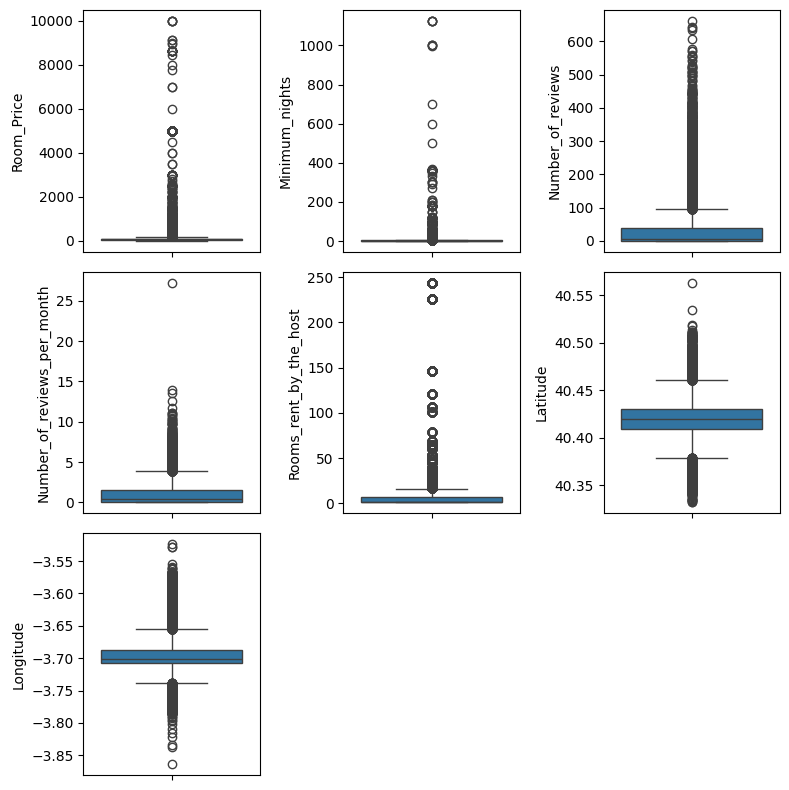

In [192]:
# Definir el tamaño de la figura
plt.figure(figsize=(8, 8))

# Calcular el número de filas y columnas necesarias para acomodar todos los subplots
num_plots = len(numeric_cols)
num_cols = int(np.ceil(np.sqrt(num_plots)))
num_rows = int(np.ceil(num_plots / num_cols))

# Crear un boxplot para cada columna numérica
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(df_airbnb_clean_vs_1[col])
    plt.tight_layout()

plt.show()

**Observacion**
A pesar de eliminar outliers, se continúa observando un % mínimo.

In [193]:
df_airbnb_clean_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9414 entries, 7 to 21252
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighbourhood                9414 non-null   object 
 1   Room_type                    9414 non-null   object 
 2   Room_Price                   9414 non-null   int64  
 3   Minimum_nights               9414 non-null   int64  
 4   Number_of_reviews            9414 non-null   int64  
 5   Number_of_reviews_per_month  9414 non-null   float64
 6   Rooms_rent_by_the_host       9414 non-null   int64  
 7   Latitude                     9414 non-null   float64
 8   Longitude                    9414 non-null   float64
 9   Availability_Cat             9414 non-null   object 
 10  Review_category              9414 non-null   object 
 11  Review_Count_Category        9414 non-null   object 
 12  Time_category                9414 non-null   object 
dtypes: float64(3), int64(4

In [194]:
df_airbnb_clean_no_outliers.isnull().sum()

Neighbourhood                  0
Room_type                      0
Room_Price                     0
Minimum_nights                 0
Number_of_reviews              0
Number_of_reviews_per_month    0
Rooms_rent_by_the_host         0
Latitude                       0
Longitude                      0
Availability_Cat               0
Review_category                0
Review_Count_Category          0
Time_category                  0
dtype: int64

In [195]:
df_airbnb_clean_no_outliers.isna().sum()

Neighbourhood                  0
Room_type                      0
Room_Price                     0
Minimum_nights                 0
Number_of_reviews              0
Number_of_reviews_per_month    0
Rooms_rent_by_the_host         0
Latitude                       0
Longitude                      0
Availability_Cat               0
Review_category                0
Review_Count_Category          0
Time_category                  0
dtype: int64

* **Transformación**

In [196]:
# Se crea una copia del dataframe original con la eliminación de la columna 'Time_category'
df_airbnb_transf_no_outliers = df_airbnb_clean_no_outliers.drop(['Number_of_reviews', 'Number_of_reviews_per_month'], axis=1)

df_airbnb_transf_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9414 entries, 7 to 21252
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighbourhood           9414 non-null   object 
 1   Room_type               9414 non-null   object 
 2   Room_Price              9414 non-null   int64  
 3   Minimum_nights          9414 non-null   int64  
 4   Rooms_rent_by_the_host  9414 non-null   int64  
 5   Latitude                9414 non-null   float64
 6   Longitude               9414 non-null   float64
 7   Availability_Cat        9414 non-null   object 
 8   Review_category         9414 non-null   object 
 9   Review_Count_Category   9414 non-null   object 
 10  Time_category           9414 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 882.6+ KB


In [197]:
# Power Transformer
numeric_cols = list(df_airbnb_transf_no_outliers._get_numeric_data().columns)
pt = PowerTransformer(method="yeo-johnson")
df_airbnb_transf_no_outliers[numeric_cols] = pt.fit_transform(df_airbnb_transf_no_outliers[numeric_cols])

In [198]:
df_airbnb_transf_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9414 entries, 7 to 21252
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighbourhood           9414 non-null   object 
 1   Room_type               9414 non-null   object 
 2   Room_Price              9414 non-null   float64
 3   Minimum_nights          9414 non-null   float64
 4   Rooms_rent_by_the_host  9414 non-null   float64
 5   Latitude                9414 non-null   float64
 6   Longitude               9414 non-null   float64
 7   Availability_Cat        9414 non-null   object 
 8   Review_category         9414 non-null   object 
 9   Review_Count_Category   9414 non-null   object 
 10  Time_category           9414 non-null   object 
dtypes: float64(5), object(6)
memory usage: 882.6+ KB


In [199]:
# Definir las columnas categóricas que quieres transformar
categorical_features = ['Room_type', 'Availability_Cat', 'Review_category', 'Review_Count_Category', 'Time_category', 'Neighbourhood']

# Crear el OneHotEncoder
encoder = OneHotEncoder(drop='first')

# Ajustar y transformar tus datos
categorical_transformed = encoder.fit_transform(df_airbnb_transf_no_outliers[categorical_features])

# Convertir a DataFrame
categorical_transformed = pd.DataFrame(categorical_transformed.toarray(), 
                                       columns=encoder.get_feature_names_out(categorical_features), 
                                       index=df_airbnb_transf_no_outliers.index)  # Mantén el mismo índice

# Eliminar las columnas categóricas originales de df_airbnb_transformed
df_airbnb_transf_no_outliers = df_airbnb_transf_no_outliers.drop(columns=categorical_features)

# Unir el DataFrame transformado con df_airbnb_transformed
df_airbnb_transf_no_outliers = pd.concat([df_airbnb_transf_no_outliers, categorical_transformed], axis=1)

df_airbnb_transf_no_outliers.head(10)

,Room_Price,Minimum_nights,Rooms_rent_by_the_host,Latitude,Longitude,Room_type_Hotel room,Room_type_Private room,Room_type_Shared room,Availability_Cat_31 a 60 días,Availability_Cat_61 a 90 días,...,Neighbourhood_San Juan Bautista,Neighbourhood_San Pascual,Neighbourhood_Sol,Neighbourhood_Trafalgar,Neighbourhood_Universidad,Neighbourhood_Valdezarza,Neighbourhood_Vallehermoso,Neighbourhood_Ventas,Neighbourhood_Vista Alegre,Neighbourhood_Zofío
7,0.586802,-1.181142,1.443455,-7.244205e-15,-1.654226,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.775030,0.985984,1.162462,-2.775558e-16,-0.077254,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-1.758277,0.223749,0.362841,-2.151057e-14,-1.298962,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.586836,0.985984,-0.861582,-1.026956e-15,-0.134664,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,-0.233950,0.985984,-0.861582,1.817990e-14,1.300463,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-1.242391,-1.181142,-0.861582,-2.334244e-14,-0.657699,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.608555,0.985984,0.362841,-5.773160e-15,0.358151,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.451372,1.471477,1.726384,-1.285083e-14,-0.083669,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.040138,-1.181142,1.658053,6.744605e-15,-0.548748,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30,-0.671501,-1.181142,0.362841,1.951217e-14,1.088446,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
df_airbnb_transf_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9414 entries, 7 to 21252
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Room_Price                            9414 non-null   float64
 1   Minimum_nights                        9414 non-null   float64
 2   Rooms_rent_by_the_host                9414 non-null   float64
 3   Latitude                              9414 non-null   float64
 4   Longitude                             9414 non-null   float64
 5   Room_type_Hotel room                  9414 non-null   float64
 6   Room_type_Private room                9414 non-null   float64
 7   Room_type_Shared room                 9414 non-null   float64
 8   Availability_Cat_31 a 60 días         9414 non-null   float64
 9   Availability_Cat_61 a 90 días         9414 non-null   float64
 10  Availability_Cat_91 a 180 días        9414 non-null   float64
 11  Availability_Cat_Hast

* **Variable objetivo (target) y atributos (feature)**

In [201]:
# Se define la variable dependiente y las independientes
x4 = df_airbnb_transf_no_outliers.drop(columns = 'Room_Price', axis=1)
y4 = df_airbnb_transf_no_outliers['Room_Price']

In [202]:
x4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9414 entries, 7 to 21252
Data columns (total 91 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Minimum_nights                        9414 non-null   float64
 1   Rooms_rent_by_the_host                9414 non-null   float64
 2   Latitude                              9414 non-null   float64
 3   Longitude                             9414 non-null   float64
 4   Room_type_Hotel room                  9414 non-null   float64
 5   Room_type_Private room                9414 non-null   float64
 6   Room_type_Shared room                 9414 non-null   float64
 7   Availability_Cat_31 a 60 días         9414 non-null   float64
 8   Availability_Cat_61 a 90 días         9414 non-null   float64
 9   Availability_Cat_91 a 180 días        9414 non-null   float64
 10  Availability_Cat_Hasta 30 días        9414 non-null   float64
 11  Availability_Cat_No d

In [203]:
#Dividir los datos de entrenamiento y test
#random_state=4
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x4, y4, random_state=42, train_size=0.8)
print(x_train_4.shape, x_test_4.shape, y_train_4.shape, y_test_4.shape)

(7531, 91) (1883, 91) (7531,) (1883,)


In [204]:
#Instanciar
rfr = RandomForestRegressor(max_depth= 25, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 100)

#Entrenar
rfr.fit(x_train_4,y_train_4)

RandomForestRegressor(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5)

In [205]:
# Predicción del modelo con los datos de entrenamiento (train data)
y_train_4_pred_rFr_4 = rfr.predict(x_train_4)

# Predicción del modelo con los datos de prueba (test data)
y_pred_rFr_4 = rfr.predict(x_test_4)

prediccion_rfr_4 = pd.DataFrame(y_pred_rFr_4, columns = ['PREDICCION'])
prediccion_rfr_4 .head()

,PREDICCION
0,-0.725048
1,0.572109
2,0.537638
3,0.433392
4,0.220894


In [206]:
# Evaluación del modelo con los datos de entrenamiento (train data)
evaluacion(y_train_4, y_train_4_pred_rFr_4)

R2 :  0.612905623147345
MAE (Error Absoluto Medio) :  0.4845265470153745


{'R2': 0.612905623147345, 'MAE': 0.4845265470153745}

In [207]:
# Evaluación del modelo con los datos de prueba (test data)
evaluacion(y_test_4, y_pred_rFr_4)

R2 :  0.45633547485344383
MAE (Error Absoluto Medio) :  0.5873916417642572


{'R2': 0.45633547485344383, 'MAE': 0.5873916417642572}

---

## 9. Resultados

In [208]:
resultados = []

# Caso base: Regresión Lineal
resultados.append({'Caso': 'Regresión Lineal', **evaluacion(y_test, y_pred_rm)})

# Caso 2: Random Forest
resultados.append({'Caso': 'Random Forest', **evaluacion(y_test, y_pred_rFr)})

# Caso 3: XGBoost 
resultados.append({'Caso': 'XGBoost', **evaluacion(y_test, y_test_pred_xgbr)})

# Caso 4.1: Random Forest sin coordenadas
# Supongamos que `y_pred_rf_sin_coordenadas` son las predicciones del modelo Random Forest sin coordenadas
resultados.append({'Caso': 'RF sin coordenadas', **evaluacion(y_test_1, y_pred_rFr_1)})

# Caso 4.2: XG Boost sin coordenadas
# Supongamos que `y_pred_rf_sin_coordenadas` son las predicciones del modelo Random Forest sin coordenadas
resultados.append({'Caso': 'XG Boost sin coordenadas', **evaluacion(y_test_1, y_test_1_pred_xgbr)})

# Caso 5.1: Random Forest sin Barrios
# Supongamos que `y_pred_rf_sin_barrios` son las predicciones del modelo Random Forest sin barrios
resultados.append({'Caso': 'RF sin Barrios', **evaluacion(y_test_3, y_pred_rFr_3)})

# Caso 5.2:  XG Boost sin Barrios
# Supongamos que `y_pred_rf_sin_barrios` son las predicciones del modelo Random Forest sin barrios
resultados.append({'Caso': 'XG Boost sin Barrios', **evaluacion(y_test_3,  y_test_pred_3_xgbr)})

# Caso 6: Random Forest sin outliers
# Supongamos que `y_pred_rf_sin_outliers` son las predicciones del modelo Random Forest sin outliers
resultados.append({'Caso': 'RF sin outliers', **evaluacion(y_test_4, y_pred_rFr_4)})

# Convertir la lista en un DataFrame
df_resultados = pd.DataFrame(resultados)

R2 :  0.06783338620150436
MAE (Error Absoluto Medio) :  180.54115271164238
R2 :  0.5059913269339145
MAE (Error Absoluto Medio) :  122.6565026477354
R2 :  0.6821359070169094
MAE (Error Absoluto Medio) :  96.86837481573957
R2 :  0.5022224583052735
MAE (Error Absoluto Medio) :  124.47161310096989
R2 :  0.679599297477101
MAE (Error Absoluto Medio) :  96.43122344512263
R2 :  0.6028301164752015
MAE (Error Absoluto Medio) :  107.91061740228815
R2 :  0.6844099309298557
MAE (Error Absoluto Medio) :  97.45087144665649
R2 :  0.45633547485344383
MAE (Error Absoluto Medio) :  0.5873916417642572


In [209]:
df_resultados.head(8)

,Caso,R2,MAE
0,Regresión Lineal,0.067833,180.541153
1,Random Forest,0.505991,122.656503
2,XGBoost,0.682136,96.868375
3,RF sin coordenadas,0.502222,124.471613
4,XG Boost sin coordenadas,0.679599,96.431223
5,RF sin Barrios,0.602830,107.910617
6,XG Boost sin Barrios,0.684410,97.450871
7,RF sin outliers,0.456335,0.587392


### 9.1. Pipeline

In [210]:
# Se crea una copia del dataframe original con la eliminación de las columnas 'Number_of_reviews' y 'Number_of_reviews_per_month'
df_airbnb_transformed = df_airbnb_clean_vs_1.drop(['Number_of_reviews', 'Number_of_reviews_per_month'], axis=1)

# Definir las columnas numéricas y categóricas
numeric_features = ['Minimum_nights', 'Rooms_rent_by_the_host', 'Latitude', 'Longitude']
categorical_features = ['Neighbourhood', 'Room_type', 'Availability_Cat', 'Review_category', 'Review_Count_Category', 'Time_category']

# Definir los transformadores para las columnas numéricas y categóricas
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(drop='first')

# Crear el modelo con los hiperparámetros obtenidos
xgbr = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=200,
    subsample=0.9,
    random_state=42
)

# Combinar los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Definir la pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgbr)
])

In [211]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_airbnb_transformed.drop('Room_Price', axis=1)
y = df_airbnb_transformed['Room_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar la pipeline con los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Usar la pipeline para hacer predicciones con los datos de prueba
predictions = pipeline.predict(X_test)

---

In [212]:
# Supongamos que new_data es el nuevo DataFrame
new_data = pd.DataFrame({
    'Minimum_nights': [3],
    'Rooms_rent_by_the_host': [13],
    'Latitude': [40.40],
    'Longitude': [-3.70175],
    'Neighbourhood': ['Embajadores'],
    'Room_type': ['Entire home/apt'],
    'Availability_Cat': ['Hasta 30 días'],
    'Review_category': ['0-1/mes'],
    'Review_Count_Category': ['11-50 reseñas'],
    'Time_category': ['8 semanas - 6 meses']
})

# Usar la pipeline para hacer predicciones
predictions = pipeline.predict(new_data)

print(predictions)

[164.99863]


In [213]:
# Usar la pipeline para hacer predicciones
predictions = pipeline.predict(new_data)

# Calcular el rango de precios basado en el MAE
lower_bound = int(predictions[0] - 96.87)
upper_bound = int(predictions[0] + 96.87)

# Redondear el precio a dos decimales
predicted_price = round(predictions[0], 2)

print(f"El precio predicho es aproximadamente {predicted_price}, con un rango de {lower_bound} a {upper_bound}.")

El precio predicho es aproximadamente 165.0, con un rango de 68 a 261.


## 10. Conclusiones y limitaciones

#### 10.1. **Conclusiones:**

Basado en los resultados se concluye lo siguiente:

* Aunque se normalizaron los outliers, no se observó una gran mejora en los datos. 

* Regresión Lineal: Este modelo tiene el rendimiento más bajo en términos de R^2 y el error absoluto medio (MAE) más alto. Esto sugiere que un modelo lineal puede no ser la mejor opción para este conjunto de datos, posiblemente porque la relación entre las características y la variable objetivo no es lineal.

* Random Forest: Este modelo mejora significativamente el rendimiento en comparación con la regresión lineal. Sin embargo, hay variaciones en el rendimiento dependiendo de las características utilizadas.

* Random Forest sin coordenadas: La eliminación de las coordenadas reduce ligeramente el rendimiento del modelo. Esto sugiere que las coordenadas son características importantes para el modelo.

* Random Forest sin Barrios: Sorprendentemente, la eliminación de los barrios mejora el rendimiento del modelo. Esto podría indicar que la característica de los barrios puede estar introduciendo ruido en el modelo, o que otras características están capturando la misma información de una manera más efectiva.

* Random Forest sin outliers: La eliminación de los outliers reduce el rendimiento del modelo, lo que sugiere que estos puntos de datos pueden contener información valiosa.

* XGBoost: Este modelo tiene el rendimiento más alto en términos de R^2 y el MAE más bajo, lo que sugiere que puede ser la mejor opción para este conjunto de datos.

* El modelo XGBoost parece ser el más preciso de los modelos que hemos probado, con un R^2 de 0.682136 y un MAE de 96.868375. Esto significa que el modelo puede explicar aproximadamente el 68.21% de la variación en los precios y que las predicciones del modelo se desvían del valor real en aproximadamente 96.87 unidades en promedio.

* Se ha utilizado un modelo para predecir el precio de una nueva entrada de datos. El precio predicho es 165.0, con un rango de precios de 68 a 261 basado en el MAE de nuestro modelo.

#### 10.2 **Limitaciones**

* Presencia de valores atípicos: los datos contienen valores atípicos, estos pueden afectar el rendimiento de nuestros modelos. Se podría considerar mejores técnicas para manejar estos valores atípicos, como truncarlos o utlizar otro tipo de transformación. 

* Aunque el modelo XGBoost tiene el mejor rendimiento de los modelos, todavía tiene un error considerable. El MAE de 96.868375 significa que las predicciones del modelo pueden desviarse bastante del valor real.

* El rango de precios que hemos calculado se basa en el MAE de nuestro modelo. Sin embargo, este rango asume que el error es uniforme, lo que puede no ser el caso. Por ejemplo, el modelo puede tener un error mayor para precios más altos que para precios más bajos.

* El rendimiento del modelo puede variar dependiendo de los datos de entrada. Por ejemplo, el modelo puede tener un rendimiento peor para ciertos barrios o tipos de habitaciones. Sería útil analizar el rendimiento del modelo para diferentes subconjuntos de los datos.

* Finalmente, aunque el modelo puede hacer predicciones razonablemente precisas, todavía hay un 31.79% de variación en los precios que el modelo no puede explicar (1 - 0.682136). Esto significa que hay otros factores que afectan al precio que nuestro modelo no está considerando.